C:\Users\lovee\AppData\Local\Temp\ipykernel_27644\2332544989.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_locat

모델이 ./dog_classifier_model_SwinTransformer.pth 경로에서 불러와졌습니다.


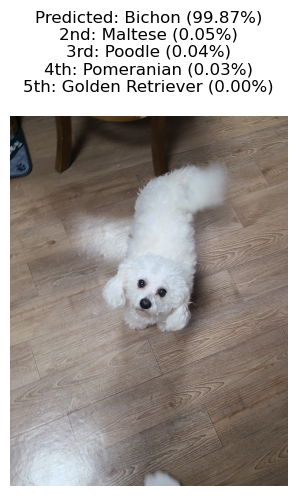

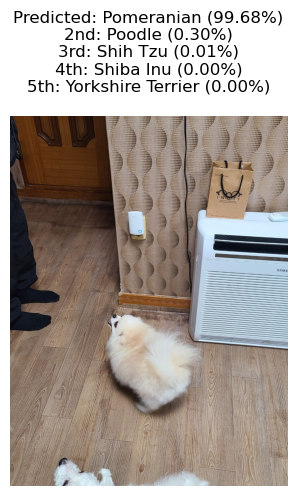

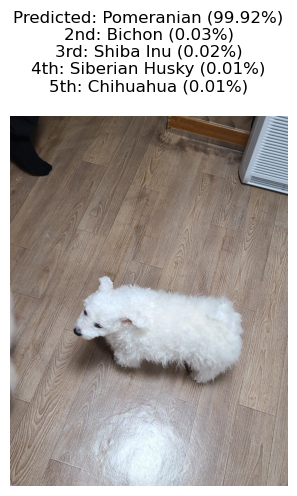

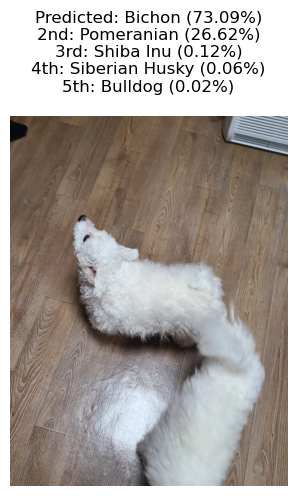

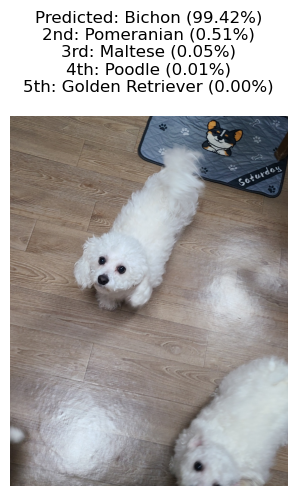

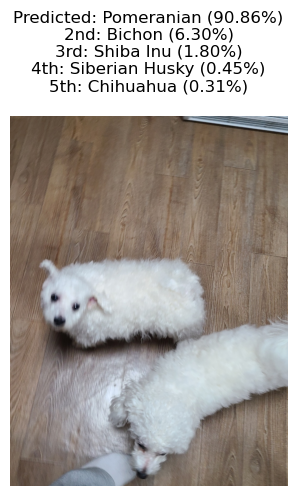

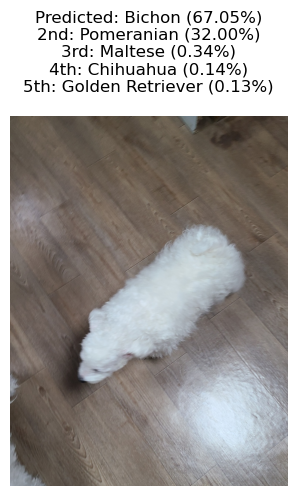

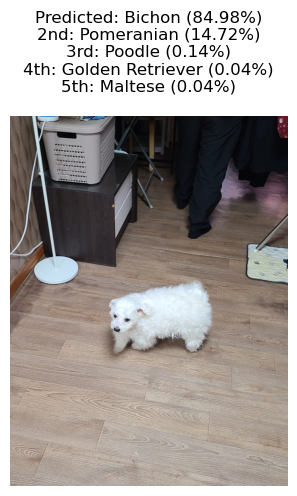

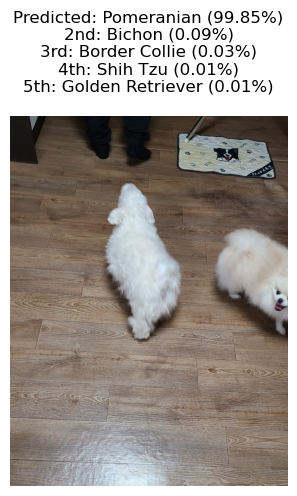

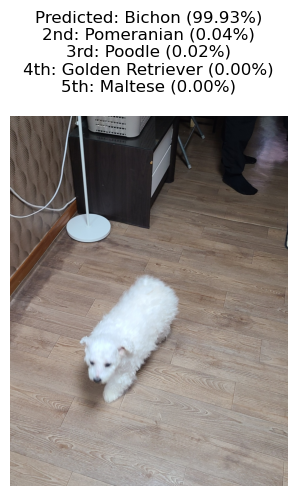

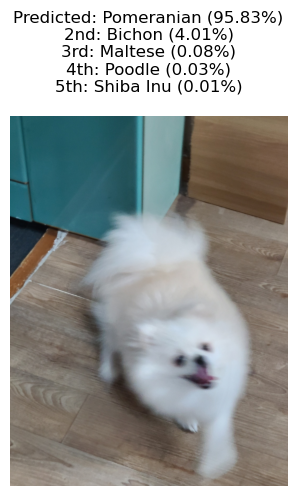

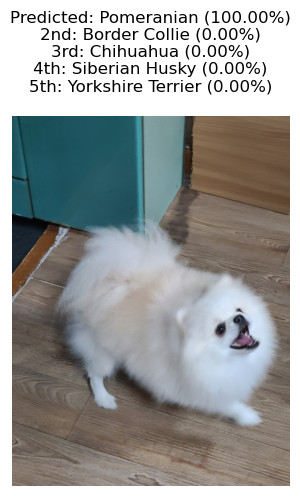

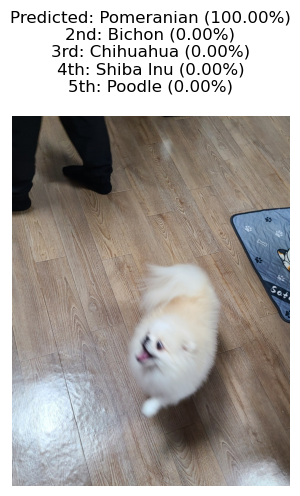

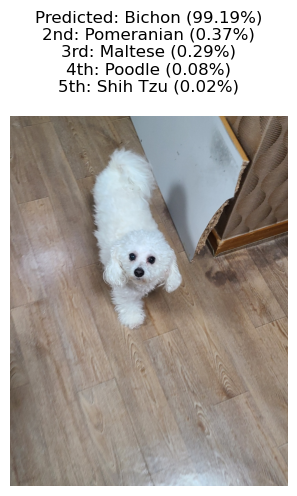

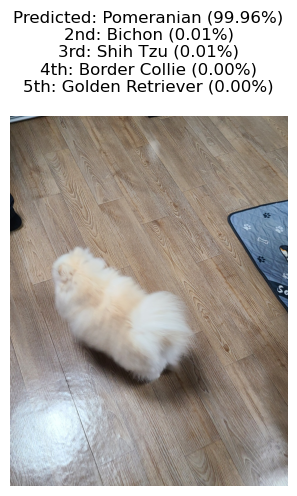

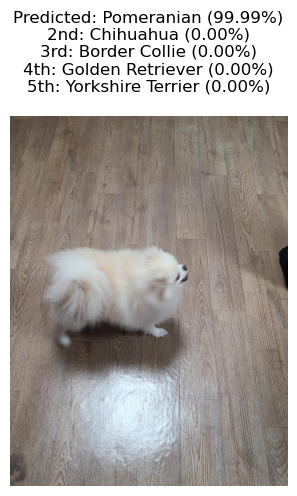

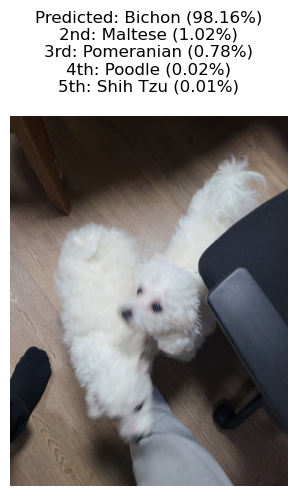

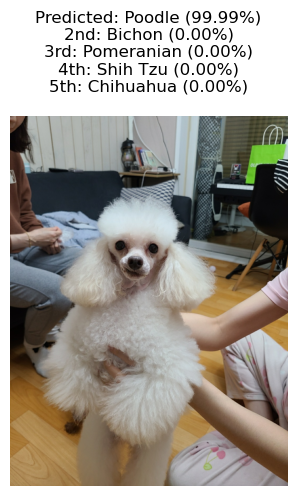

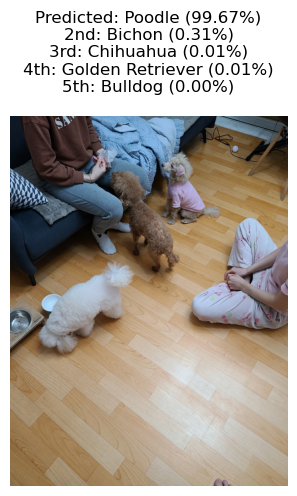

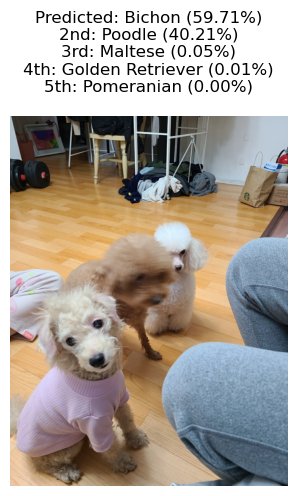

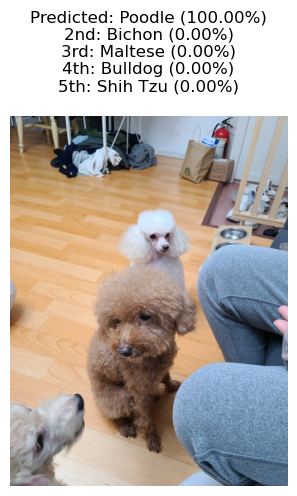

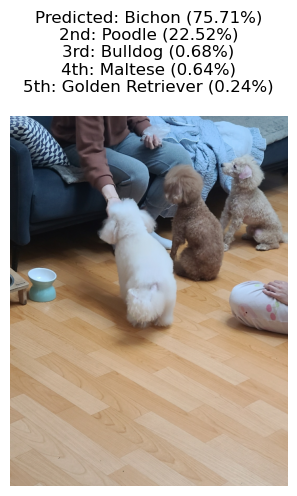

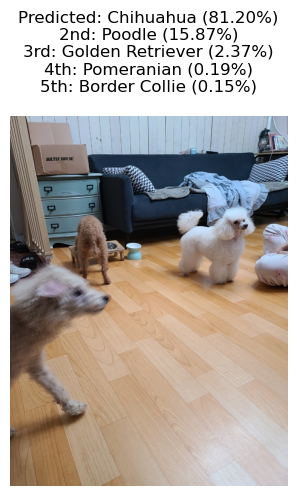

In [3]:
import torch
import timm
import torch.nn as nn
import torchvision.transforms as transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import gc

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Swin Transformer 모델 정의 (출력 클래스 수를 저장된 모델과 동일하게 설정)
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=12)

# 모델을 GPU로 이동
model = model.to(device)

# 가중치 불러오기 (GPU 학습된 모델을 GPU로 불러오기)
model_load_path = "./dog_classifier_model_SwinTransformer.pth"
model.load_state_dict(torch.load(model_load_path, map_location=device))

# 평가 모드로 전환
model.eval()

print(f"모델이 {model_load_path} 경로에서 불러와졌습니다.")

# 클래스 레이블 정의 (학습 시 사용한 클래스 레이블 리스트)
class_labels = [
    "Bichon", "Border Collie", "Bulldog", "Chihuahua", "Golden Retriever",
    "Maltese", "Pomeranian", "Poodle", "Shiba Inu", "Shih Tzu", "Siberian Husky",
    "Yorkshire Terrier"
]

# 이미지 전처리 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델이 기대하는 입력 크기로 변경
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet과 동일한 정규화 사용
])

# 새로운 이미지들의 경로를 폴더로 설정
new_images_dir = 'testDog'
new_images = [os.path.join(new_images_dir, img) for img in os.listdir(new_images_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

# 이미지 분류 및 결과 출력
for img_path in new_images:
    try:
        # 이미지 파일을 열고 RGB로 변환
        image = Image.open(img_path).convert("RGB")
        # 전처리 및 배치 차원 추가
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)  # 확률 계산
            top3_prob, top3_classes = torch.topk(probabilities, 5)  # 상위 5개의 확률과 클래스 추출

        # 결과 시각화 - 예측된 클래스 인덱스를 클래스 이름으로 변환하여 출력
        plt.imshow(Image.open(img_path))
        plt.title(f"Predicted: {class_labels[top3_classes[0]]} ({top3_prob[0].item() * 100:.2f}%)\n"
                  f"2nd: {class_labels[top3_classes[1]]} ({top3_prob[1].item() * 100:.2f}%)\n"
                  f"3rd: {class_labels[top3_classes[2]]} ({top3_prob[2].item() * 100:.2f}%)\n"
                  f"4th: {class_labels[top3_classes[3]]} ({top3_prob[3].item() * 100:.2f}%)\n"
                  f"5th: {class_labels[top3_classes[4]]} ({top3_prob[4].item() * 100:.2f}%)\n")
        plt.axis('off')
        plt.show()

        # 메모리 정리
        torch.cuda.empty_cache()  # GPU 메모리 정리
        plt.close()  # 플롯을 닫아 메모리 확보
        gc.collect()  # 가비지 콜렉션 실행

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
